## Tutorial 08 - Non linear Parabolic problem
**_Keywords: exact parametrized functions, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider the FitzHugh-Nagumo (F-N) system. The F-N system is used to describe neuron excitable systems. The nonlinear parabolic problem for the F-N system is defined on the interval $I=[0,L]$. Let $x\in I$, $t\geq0$

$$\begin{cases} 
    \varepsilon u_t(x,t) =\varepsilon^2u_{xx}(x,t)+g(u(x,t))-\omega(x,t)+c, & x\in I,\quad t\geq 0, \\
    \omega_t(x,t) =bu(x,t)-\gamma\omega(x,t)+c, & x\in I,\quad t\geq 0, \\
    u(x,0) = 0,\quad\omega(x,0)=0, & x\in I, \\
    u_x(0,t)=-i_0(t),\quad u_x(L,t)=0, & t\geq 0,
\end{cases}$$

where the nonlinear function is defined by
$$g(u) = u(u-0.1)(1-u)$$

and the parameters are given by $L = 1$, $\varepsilon = 0.015$, $b = 0.5$, $\gamma = 2$, and $c = 0.05$. The stimulus $i_0(t)=50000t^3\exp(-15t)$. The variables $u$ and $\omega$ represent the $\textit{voltage}$ and the $\textit{recovery of voltage}$, respectively. 

In order to obtain an exact solution of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Formulation for the F-N system

Let $u,\omega$ the solutions in the domain $I$.

For this problem we want to find $\boldsymbol{u}=(u,\omega)$ such that

$$
m\left(\partial_t\boldsymbol{u}(t),\boldsymbol{v}\right)+a\left(\boldsymbol{u}(t),\boldsymbol{v}\right)+c\left(u(t),v\right)=f(\boldsymbol{v})\quad \forall \boldsymbol{v}=(v,\tilde{v}), \text{ with }v,\tilde{v} \in\mathbb{V},\quad\forall t\geq0
$$



where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in L^2(I) : v|_{\{0\}}=0\}
$$
* the bilinear form $m(\cdot, \cdot): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$m(\partial\boldsymbol{u}(t), \boldsymbol{v})=\varepsilon\int_{I}\frac{\partial u}{\partial t}v \ d\boldsymbol{x} \ + \ \int_{I}\frac{\partial\omega}{\partial t}\tilde{v} \ d\boldsymbol{x},$$
* the bilinear form $a(\cdot, \cdot): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(\boldsymbol{u}(t), \boldsymbol{v})=\varepsilon^2\int_{I} \nabla u\cdot \nabla v \ d\boldsymbol{x}+\int_{I}\omega v \ d\boldsymbol{x} \ - \ b\int_{I} u\tilde{v} \ d\boldsymbol{x}+\gamma\int_{I}\omega\tilde{v} \ d\boldsymbol{x},$$
* the bilinear form $c(\cdot, \cdot): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v)=-\int_{I} g(u)v \ d\boldsymbol{x},$$
* the linear form $f(\cdot): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(\boldsymbol{v})= c\int_{I}\left(v+\tilde{v}\right) \ d\boldsymbol{x} \ + \ \varepsilon^2i_0(t)\int_{\{0\}}v \ d\boldsymbol{s}.$$

The output of interest $s(t)$ is given by
$$s(t) = c\int_{I}\left[u(t)+\omega(t)\right] \ d\boldsymbol{x} \ + \ \varepsilon^2i_0(t)\int_{\{0\}}u(t) \ d\boldsymbol{s} $$.

In [1]:
import sys
sys.path.append("../../MLniCS/")


from mlnics import NN, Losses, Normalization
from dolfin import *
from rbnics import *
from utils import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

We set the variables $u:=u_1$, $\omega:=u_2$ and the test functions $v:=v_1$, $\tilde{v}:=v_2$.
For this problem the affine decomposition is straightforward:
    $$m(\boldsymbol{u},\boldsymbol{v})=\underbrace{\varepsilon}_{\Theta^{m}_0}\underbrace{\int_{I}u_1v_1 \ d\boldsymbol{x}}_{m_0(u_1,v_1)} \ + \ \underbrace{1}_{\Theta^{m}_1}\underbrace{\int_{I}u_2v_2 \ d\boldsymbol{x}}_{m_1(u_2,v_2)},$$
$$a(\boldsymbol{u},\boldsymbol{v})=\underbrace{\varepsilon^2}_{\Theta^{a}_0}\underbrace{\int_{I}\nabla u_1 \cdot \nabla v_1 \ d\boldsymbol{x}}_{a_0(u_1,v_1)} \ + \ \underbrace{1}_{\Theta^{a}_1}\underbrace{\int_{I}u_2v_1 \ d\boldsymbol{x}}_{a_1(u_2,v_1)} \ + \ \underbrace{-b}_{\Theta^{a}_2}\underbrace{\int_{I}u_1v_2 \ d\boldsymbol{x}}_{a_2(u_1,v_2)} \ + \ \underbrace{\gamma}_{\Theta^{a}_3}\underbrace{\int_{I}u_2v_2 \ d\boldsymbol{x}}_{a_3(u_2,v_2)},$$
$$c(u,v)=\underbrace{-1}_{\Theta^{c}_0}\underbrace{\int_{I}g(u_1)v_1 \ d\boldsymbol{x}}_{c_0(u_1,v_1)},$$
$$f(\boldsymbol{v}) = \underbrace{c}_{\Theta^{f}_0} \underbrace{\int_{I}(v_1 + v_2) \ d\boldsymbol{x}}_{f_0(v_1,v_2)} \ + \ \underbrace{\varepsilon^2i_0(t)}_{\Theta^{f}_1} \underbrace{\int_{\{0\}} v_1 \ d\boldsymbol{s}}_{f_1(v_1)}.$$
We will implement the numerical discretization of the problem in the class
```
class FitzHughNagumo(NonlinearParabolicProblem):
```
by specifying the coefficients $\Theta^{m}_*$, $\Theta^{a}_*$, $\Theta^{c}_*$ and $\Theta^{f}_*$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $m_*(\boldsymbol{u}, \boldsymbol{v})$, $a_*(\boldsymbol{u}, \boldsymbol{v})$, $c_*(u, v)$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [2]:
@ExactParametrizedFunctions()
class FitzHughNagumo(NonlinearParabolicProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearParabolicProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        (self.du1, self.du2) = split(self.du)
        self.u = self._solution
        (self.u1, self.u2) = split(self.u)
        self.v = TestFunction(V)
        (self.v1, self.v2) = split(self.v)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Problem coefficients
        self.epsilon = 0.015
        self.b = 0.5
        self.gamma = 2
        self.c = 0.05
        self.i0 = lambda t: 50000 * t**3 * exp(-15 * t)
        self.g = lambda v: v * (v - 0.1) * (1 - v)
        # Customize time stepping parameters
        self._time_stepping_parameters.update({
            "report": True,
            "snes_solver": {
                "linear_solver": "umfpack",
                "maximum_iterations": 20,
                "report": True
            }
        })

    # Return custom problem name
    def name(self):
        return "FitzHughNagumoExact"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        if term == "m":
            theta_m0 = self.epsilon
            theta_m1 = 1.
            return (theta_m0, theta_m1)
        elif term == "a":
            theta_a0 = self.epsilon**2
            theta_a1 = 1.
            theta_a2 = - self.b
            theta_a3 = self.gamma
            return (theta_a0, theta_a1, theta_a2, theta_a3)
        elif term == "c":
            theta_c0 = - 1.
            return (theta_c0,)
        elif term == "f":
            t = self.t
            theta_f0 = self.c
            theta_f1 = self.epsilon**2 * self.i0(t)
            return (theta_f0, theta_f1)
        elif term == "s":
            t = self.t
            theta_s0 = self.c
            theta_s1 = self.epsilon**2 * self.i0(t)
            return (theta_s0, theta_s1)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        (v1, v2) = (self.v1, self.v2)
        dx = self.dx
        if term == "m":
            (u1, u2) = (self.du1, self.du2)
            m0 = u1 * v1 * dx
            m1 = u2 * v2 * dx
            return (m0, m1)
        elif term == "a":
            (u1, u2) = (self.du1, self.du2)
            a0 = inner(grad(u1), grad(v1)) * dx
            a1 = u2 * v1 * dx
            a2 = u1 * v2 * dx
            a3 = u2 * v2 * dx
            return (a0, a1, a2, a3)
        elif term == "c":
            u1 = self.u1
            c0 = self.g(u1) * v1 * dx
            return (c0,)
        elif term == "f":
            ds = self.ds
            f0 = v1 * dx + v2 * dx
            f1 = v1 * ds(1)
            return (f0, f1)
        elif term == "s":
            (v1, v2) = (self.v1, self.v2)
            ds = self.ds
            s0 = v1 * dx + v2 * dx
            s1 = v1 * ds(1)
            return (s0, s1)
        elif term == "inner_product":
            (u1, u2) = (self.du1, self.du2)
            x0 = inner(grad(u1), grad(v1)) * dx + u2 * v2 * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearParabolicProblem)
def CustomizeReducedNonlinearParabolic(ReducedNonlinearParabolic_Base):
    class ReducedNonlinearParabolic(ReducedNonlinearParabolic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearParabolic_Base.__init__(self, truth_problem, **kwargs)
            self._time_stepping_parameters.update({
                "report": True,
                "nonlinear_solver": {
                    "report": True,
                    "line_search": "wolfe"
                }
            })

    return ReducedNonlinearParabolic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/interval.xml")
subdomains = MeshFunction("size_t", mesh, "data/interval_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/interval_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = VectorFunctionSpace(mesh, "Lagrange", 1, dim=2)

### 4.3. Allocate an object of the FitzHughNagumo class

In [5]:
problem = FitzHughNagumo(V, subdomains=subdomains, boundaries=boundaries)
mu_range = []
problem.set_mu_range(mu_range)
problem.set_time_step_size(0.02)
problem.set_final_time(1)#8)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(1)
reduced_problem = reduction_method.offline()

=            FitzHughNagumoExact POD-Galerkin offline phase begins             =

###################################### 0 #######################################
truth solve for mu = ()
# t = 0.02
  0 SNES Function norm 2.210911e-03
  1 SNES Function norm 1.063340e-04
  2 SNES Function norm 6.047399e-07
  3 SNES Function norm 1.982447e-11
# t = 0.04
  0 SNES Function norm 2.849024e-03
  1 SNES Function norm 1.010348e-04
  2 SNES Function norm 5.953550e-07
  3 SNES Function norm 2.184160e-11
# t = 0.06
  0 SNES Function norm 3.734542e-03
  1 SNES Function norm 1.217784e-04
  2 SNES Function norm 7.911830e-07
  3 SNES Function norm 3.547206e-11
# t = 0.08
  0 SNES Function norm 4.968389e-03
  1 SNES Function norm 1.423033e-04
  2 SNES Function norm 3.604419e-07
  3 SNES Function norm 2.124304e-12
# t = 0.1
  0 SNES Function norm 6.954749e-03
  1 SNES Function norm 5.282859e-04
  2 SNES Function norm 3.852334e-05
  3 SNES Function norm 2.557857e-07
  4 SNES Function norm 1.124143e-11
# t

In [32]:
net = NN.RONN(problem, reduction_method)

In [33]:
input_normalization = Normalization.StandardNormalization()
output_normalization = Normalization.IdentityNormalization()

In [34]:
pdnn_loss = Losses.PDNN_Loss(net, output_normalization)
pinn_loss = Losses.PINN_Loss(net)
prnn_loss = Losses.PRNN_Loss(net, output_normalization, omega=1.)

In [65]:
NN.normalize_and_train(net, pdnn_loss, input_normalization, 
                       lr=0.000001, epochs=100000)

0 3.0619151334176325e-08
100 3.061470531606802e-08
200 3.0610885472418314e-08
300 3.0604818751384084e-08
400 3.0596162718946653e-08
500 3.0588821157875066e-08
600 3.0578222023192194e-08
700 3.05701388654927e-08
800 3.0559138672420725e-08
900 3.054566403599957e-08
1000 3.0534644490738776e-08
1100 3.052096832632277e-08
1200 3.051127490364798e-08
1300 3.0496324168672207e-08
1400 3.049463601513485e-08
1500 3.0475693813711153e-08
1600 3.045600355843101e-08
1700 3.0442466354479184e-08
1800 3.042538311002754e-08
1900 3.0411589851423376e-08
2000 3.040085463917264e-08
2100 3.038531283517794e-08
2200 3.038573406968408e-08
2300 3.035349012893817e-08
2400 3.035342889049501e-08
2500 3.032345486890958e-08
2600 3.032675734301838e-08
2700 3.029050076915748e-08
2800 3.028143568786243e-08
2900 3.026225521760265e-08
3000 3.026240308374134e-08
3100 3.02383317273238e-08
3200 3.022432407432968e-08
3300 3.020300989126208e-08
3400 3.019258220086284e-08
3500 3.017534083548666e-08
3600 3.01597943075366e-08
3700

29100 2.690934540127301e-08
29200 2.6898493104407196e-08
29300 2.69106866892377e-08
29400 2.6875374074697074e-08
29500 2.6870035083098842e-08
29600 2.6853544485803806e-08
29700 2.6843652882554455e-08
29800 2.6832535411852926e-08
29900 2.682526922075878e-08
30000 2.6816059336820778e-08
30100 2.6800248246593934e-08
30200 2.679868528286223e-08
30300 2.6782018118418178e-08
30400 2.6765000396039448e-08
30500 2.6756874693049076e-08
30600 2.674619937078827e-08
30700 2.6751142250006623e-08
30800 2.67490452072286e-08
30900 2.6714601318241303e-08
31000 2.6704509586266012e-08
31100 2.6694145894798605e-08
31200 2.669012642471612e-08
31300 2.6671716190968076e-08
31400 2.6661893465170056e-08
31500 2.6684099846439886e-08
31600 2.6641520687032997e-08
31700 2.6631313713518634e-08
31800 2.6620611370911412e-08
31900 2.661608762884684e-08
32000 2.6597900531533853e-08
32100 2.6591586707865128e-08
32200 2.6577433283787724e-08
32300 2.6566976111248852e-08
32400 2.6579789632501928e-08
32500 2.65492089505528e-

57800 2.424153697530324e-08
57900 2.423201805750325e-08
58000 2.4241648971673263e-08
58100 2.421694648314843e-08
58200 2.422387685152296e-08
58300 2.420188955214082e-08
58400 2.4192429542932168e-08
58500 2.4186638358237058e-08
58600 2.4179160890815537e-08
58700 2.417167393008998e-08
58800 2.4166684337473625e-08
58900 2.4167545883759253e-08
59000 2.416026722361786e-08
59100 2.4165784908130546e-08
59200 2.4131212405459486e-08
59300 2.4123805905717434e-08
59400 2.411825945214095e-08
59500 2.4108937475129468e-08
59600 2.4111888625200556e-08
59700 2.4089564488780388e-08
59800 2.4082089847118238e-08
59900 2.4074038872688463e-08
60000 2.407000001690142e-08
60100 2.4062484852742558e-08
60200 2.4052927520386037e-08
60300 2.405358503595446e-08
60400 2.4060434983945557e-08
60500 2.4027347951638954e-08
60600 2.401949944774492e-08
60700 2.4017531321575327e-08
60800 2.400569241389872e-08
60900 2.3996882049814208e-08
61000 2.399148791599291e-08
61100 2.3981197534057673e-08
61200 2.3973306832779038e-0

86400 2.224986569159226e-08
86500 2.2222124143018153e-08
86600 2.2218390070376208e-08
86700 2.220884800644554e-08
86800 2.2203340923441648e-08
86900 2.21952077112513e-08
87000 2.2191520112644986e-08
87100 2.2188686025161875e-08
87200 2.2179906116267548e-08
87300 2.2182058000361734e-08
87400 2.2176919287777705e-08
87500 2.2164183641353182e-08
87600 2.215458495009682e-08
87700 2.2147833875403916e-08
87800 2.2155885432102383e-08
87900 2.215249347204928e-08
88000 2.2148417837696703e-08
88100 2.212190552016058e-08
88200 2.212598466728559e-08
88300 2.2111314606341623e-08
88400 2.2121766827421596e-08
88500 2.2101993929245074e-08
88600 2.2095087284938755e-08
88700 2.2089721258333523e-08
88800 2.208043083751007e-08
88900 2.2074845619293278e-08
89000 2.207815678923383e-08
89100 2.2073831481826432e-08
89200 2.2057254172603237e-08
89300 2.2048438510315864e-08
89400 2.206326360237202e-08
89500 2.20384257407641e-08
89600 2.2031976887507418e-08
89700 2.202459929138407e-08
89800 2.2018277506086802e-08

### 4.6. Perform an online solve

In [76]:
solution_over_time = problem.solve()
reduced_solution_over_time = reduced_problem.solve()
basis_functions = reduced_problem.basis_functions

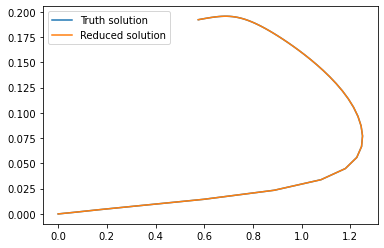

In [67]:
plot_phase_space(solution_over_time, reduced_solution_over_time, basis_functions, 0.0)

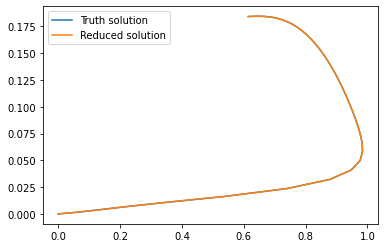

In [68]:
plot_phase_space(solution_over_time, reduced_solution_over_time, basis_functions, 0.1)

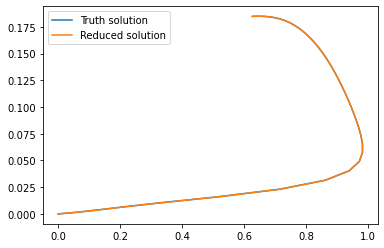

In [69]:
plot_phase_space(solution_over_time, reduced_solution_over_time, basis_functions, 0.5)

In [79]:
net.eval()
with torch.no_grad():
    online_mu_nn = torch.tensor([])
    reduced_solution_nn = net.solve(online_mu_nn, input_normalization, output_normalization=None)
net.train()

RONN(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=20, bias=True)
  )
)

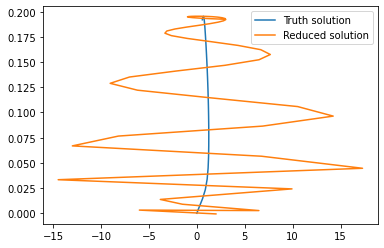

In [80]:
plot_phase_space(solution_over_time, reduced_solution_nn, basis_functions, 0.0)

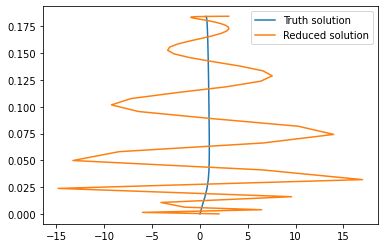

In [81]:
plot_phase_space(solution_over_time, reduced_solution_nn, basis_functions, 0.1)

In [75]:
for i in range(len(reduced_solution_over_time)):
    print(np.mean((np.array(reduced_solution_over_time[i].vector()) - np.array(reduced_solution_nn[i].vector()))**2))

5.327806357376119e-09
4.013025171682815e-08
5.39664441255459e-08
3.1979586260672966e-08
1.8867193229361098e-08
1.4809558153106901e-08
1.3001069789105592e-08
1.743798960054658e-08
1.1010427043049691e-08
9.95207043570205e-09
8.225778779382815e-09
1.0599797245629098e-08
4.3347941954486945e-09
5.904889948017551e-09
9.947575517639073e-09
6.2317672331463756e-09
2.341332392160798e-09
4.422713166864646e-09
7.63754562209627e-09
6.930481799602624e-09
3.981308888121607e-09
2.912410944811214e-09
4.447980616892445e-09
6.035414970486365e-09
5.704992624123813e-09
4.28479795611899e-09
3.974726050165448e-09
5.696566096174894e-09
8.05537230139399e-09
8.765741164863466e-09
6.9306188364936935e-09
4.090233851629274e-09
3.1365371983324907e-09
5.880212248203242e-09
1.1264269061322546e-08
1.5682452363984443e-08
1.5477740945743945e-08
1.0143527278435523e-08
3.7284522140072264e-09
2.8558038156310682e-09
1.1846162009812643e-08
2.7814549190415455e-08
4.011503696905487e-08
3.687541325823761e-08
1.7367845310107623e

### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(1)
reduction_method.error_analysis()

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()